In [1]:
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import cv2
from PIL import Image, ImageDraw
from lang_sam import LangSAM
from matplotlib import pyplot as plt

load_dotenv()
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
options = os.getenv("OPTIONS").split(",")
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
features = os.getenv("FEATURES").split(",")

image = cv2.imread("parking2.jpg")
image_height, image_width, _ = image.shape
image_area = image_width * image_height

c:\Python311\Lib\site-packages\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [187]:
query = "Select the red car."

In [45]:
sentence_embedding = sentence_model.encode([query])[0]
options_embeddings = sentence_model.encode(options)

similarities = {}
for i, option in enumerate(options):
    similarity = np.dot(sentence_embedding, options_embeddings[i]) / (np.linalg.norm(sentence_embedding) * np.linalg.norm(options_embeddings[i]))
    similarities[option] = similarity

best_option = max(similarities, key=similarities.get)

print(f"Most Probability world is '{best_option}' with similarity {similarities[best_option]:.4f}")

Most Probability world is 'car' with similarity 0.6655


In [4]:
def get_filter_code(prompt: str) -> str:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=prompt,
        max_tokens=1000,
        temperature=0,
    )
    
    return response.choices[0].message.content

In [10]:
model_sam = LangSAM()
image_pil = Image.open("parking2.jpg").convert("RGB")
results = model_sam.predict([image_pil], [f"{best_option}."], box_threshold=0.23)

Predicting 1 masks
Predicted 1 masks


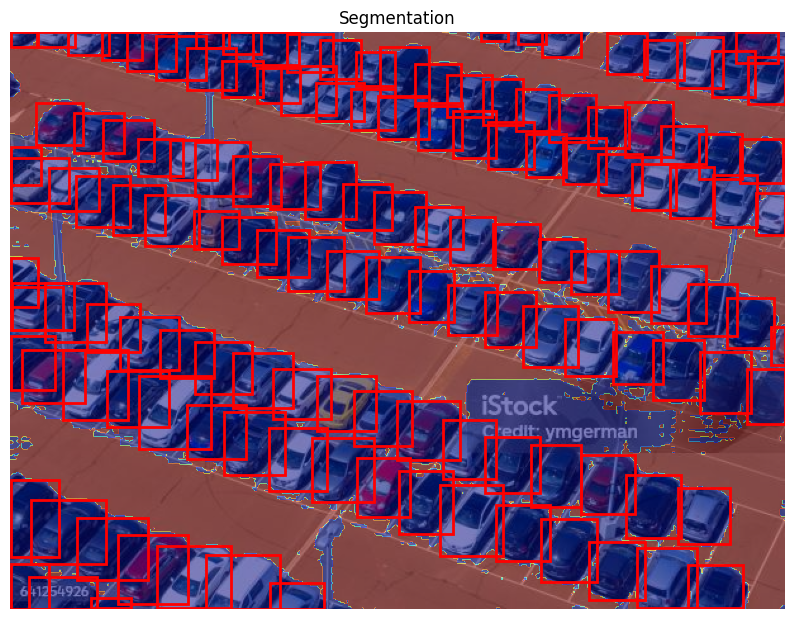

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image_pil)
plt.axis('off')

for result in results:
    # Itera sulle copie dei box per filtrare quelli da rimuovere
    for i, box in enumerate(result["boxes"]):
        x_min, y_min, x_max, y_max = box
        area = (x_max - x_min) * (y_max - y_min) / image_area
        if area > 0.8:
            # Rimuovi il box con numpy.delete
            result["boxes"] = np.delete(result["boxes"], i, axis=0)
            continue
        # Disegna il box valido
        plt.gca().add_patch(plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            edgecolor='red', facecolor='none', linewidth=2, label="Box"
        ))

    # Visualizza la maschera
    mask = result["masks"][0]
    plt.imshow(mask, cmap='jet', alpha=0.5)

plt.title("Segmentation")
plt.show()

In [172]:
def calculate_features(points, image):
    import cv2
    import numpy as np

    # Determine the bounding rectangle limits
    x_min = int(min(p[0] for p in points))
    x_max = int(max(p[0] for p in points))
    y_min = int(min(p[1] for p in points))
    y_max = int(max(p[1] for p in points))

    # Calculate area and relative dimensions
    area = (x_max - x_min) * (y_max - y_min)
    image_area = image.shape[0] * image.shape[1]
    relative_area = area / image_area
    relative_height = (y_max - y_min) / image.shape[0]
    relative_width = (x_max - x_min) / image.shape[1]

    # Mean coordinates
    mean_x = np.mean([p[0] for p in points])
    mean_y = np.mean([p[1] for p in points])

    # Crop the specified area
    cropped_area = image[y_min:y_max, x_min:x_max]

    # Convert the image to HSV
    cropped_hsv = cv2.cvtColor(cropped_area, cv2.COLOR_BGR2HSV)

    # Define color ranges in HSV with adjusted blue range
    color_ranges = {
        'black':  {'lower': np.array([0, 0, 0]),      'upper': np.array([180, 255, 50])},
        'white':  {'lower': np.array([0, 0, 200]),    'upper': np.array([180, 30, 255])},
        'gray':   {'lower': np.array([0, 0, 51]),     'upper': np.array([180, 50, 199])},
        'red1':   {'lower': np.array([0, 50, 50]),    'upper': np.array([10, 255, 255])},
        'red2':   {'lower': np.array([160, 50, 50]),  'upper': np.array([180, 255, 255])},
        'orange': {'lower': np.array([11, 50, 50]),   'upper': np.array([25, 255, 255])},
        'yellow': {'lower': np.array([26, 50, 50]),   'upper': np.array([34, 255, 255])},
        'green':  {'lower': np.array([35, 50, 50]),   'upper': np.array([85, 255, 255])},
        'blue':   {'lower': np.array([100, 150, 50]), 'upper': np.array([115, 255, 200])},  # Further adjusted blue range
        'purple': {'lower': np.array([126, 50, 50]),  'upper': np.array([159, 255, 255])}
    }

    # Initialize a dictionary to hold pixel counts for each color
    color_counts = {color: 0 for color in color_ranges.keys()}
    total_pixels = cropped_hsv.shape[0] * cropped_hsv.shape[1]

    # Apply color masks and count pixels
    for color, bounds in color_ranges.items():
        mask = cv2.inRange(cropped_hsv, bounds['lower'], bounds['upper'])

        # Apply morphological operations for blue
        if color == 'blue':
            # Remove small objects
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            # Exclude upper regions (e.g., reflections from windows)
            height = mask.shape[0]
            reflection_region = int(height * 0.2)
            spatial_mask = np.zeros_like(mask)
            spatial_mask[reflection_region:, :] = 255  # Include only lower 80%
            mask = cv2.bitwise_and(mask, mask, mask=spatial_mask)

        # Exclude windows if desired
        # ... (Include the window exclusion code here if needed)

        count = cv2.countNonZero(mask)
        color_counts[color] += count

    # Combine counts for red ranges
    red_count = color_counts['red1'] + color_counts['red2']
    color_counts['red'] = red_count
    del color_counts['red1']
    del color_counts['red2']

    # Remove black and white from total color pixels if necessary
    total_color_pixels = sum(color_counts.values()) - color_counts.get('black', 0) - color_counts.get('white', 0)

    # Calculate ratios
    blue_ratio = color_counts['blue'] / total_color_pixels if total_color_pixels > 0 else 0

    # Determine the dominant color
    # Exclude blue if ratio is below threshold
    if blue_ratio < 0.2:
        color_counts['blue'] = 0

    dominant_color = max(color_counts, key=color_counts.get)
    dominant_count = color_counts[dominant_color]
    dominant_percentage = (dominant_count / total_pixels) * 100

    # Set a minimum threshold percentage for classification
    min_threshold = 10  # Adjusted threshold

    if dominant_percentage < min_threshold:
        color_category = 'other'
    else:
        color_category = dominant_color

    # Return the calculated features
    return {
        "coord_1": points[0],
        "coord_2": points[1],
        "coord_3": points[2],
        "coord_4": points[3],
        "mean_x": mean_x,
        "mean_y": mean_y,
        "color_category": color_category,
        "area": area,
        "relative_area": relative_area,
        "relative_height": relative_height,
        "relative_width": relative_width
    }


In [173]:
import numpy as np
import pandas as pd

# Supponendo che 'results[0]['boxes']' sia una lista di bounding box nel formato [x_min, y_min, x_max, y_max]
points_array = np.array([
    [
        [row[0], row[1]],  # Punto superiore sinistro
        [row[2], row[1]],  # Punto superiore destro
        [row[2], row[3]],  # Punto inferiore destro
        [row[0], row[3]]   # Punto inferiore sinistro
    ]
    for row in results[0]['boxes']
])

dataset = []
for points in points_array:
    features_dict = calculate_features(points, image)
    dataset.append(features_dict)

df = pd.DataFrame(dataset)
print(df.head())


                    coord_1                    coord_2  \
0     [527.3987, 360.08112]     [567.73444, 360.08112]   
1  [419.6571, -0.035330236]  [450.19617, -0.035330236]   
2     [588.2431, 126.95752]      [611.5698, 126.95752]   
3     [535.1211, 421.09146]      [578.1148, 421.09146]   
4     [416.9762, 162.96815]      [453.8191, 162.96815]   

                  coord_3                coord_4      mean_x      mean_y  \
0   [567.73444, 403.8291]   [527.3987, 403.8291]  547.566528  381.955109   
1  [450.19617, 19.702547]  [419.6571, 19.702547]  434.926636    9.833609   
2   [611.5698, 160.15787]  [588.2431, 160.15787]  599.906494  143.557693   
3   [578.1148, 454.92853]  [535.1211, 454.92853]  556.617920  438.010010   
4   [453.8191, 197.03537]  [416.9762, 197.03537]  435.397644  180.001770   

  color_category  area  relative_area  relative_height  relative_width  
0           gray  1720       0.006163         0.094298        0.065359  
1           gray   589       0.002111         0.

In [174]:
df['color_category'].value_counts()

gray      61
black     30
red       15
white     14
blue      12
other      3
orange     2
Name: color_category, dtype: int64

In [188]:
messages = [
    {"role": "system", "content": "You are an assistant that helps write Python code."},
    {"role": "user", "content": 
    f"""
        Considering the following {df.columns} columns in pandas dataframes. Image dimensions are {image_width}x{image_height} and the area is {image_area}.
        The user's query is: "{query}".

        If the query includes a color filter:
        - If a specific color name is provided, use the color_category column to filter rows where the color_category matches the requested color.
        - If an RGB range is provided, filter rows where the mean_color_R, mean_color_G, and mean_color_B columns fall within the specified range or infer a default tolerance of {tolerance} per channel if not provided.

        Write the Python code based on the query and assign to a variable called filtered_data. Notice that you have to aggregate in some cases. 
        Do not include comments or import statements or library, only the Python code.
        """}
]
try:
    filter_code = get_filter_code(prompt=messages).replace("```python", "").replace("```", "").strip()
    print(filter_code)
    exec(filter_code)
except Exception as e:
    print(f"An error occurred: {e}")

filtered_data = df[df['color_category'] == 'red']


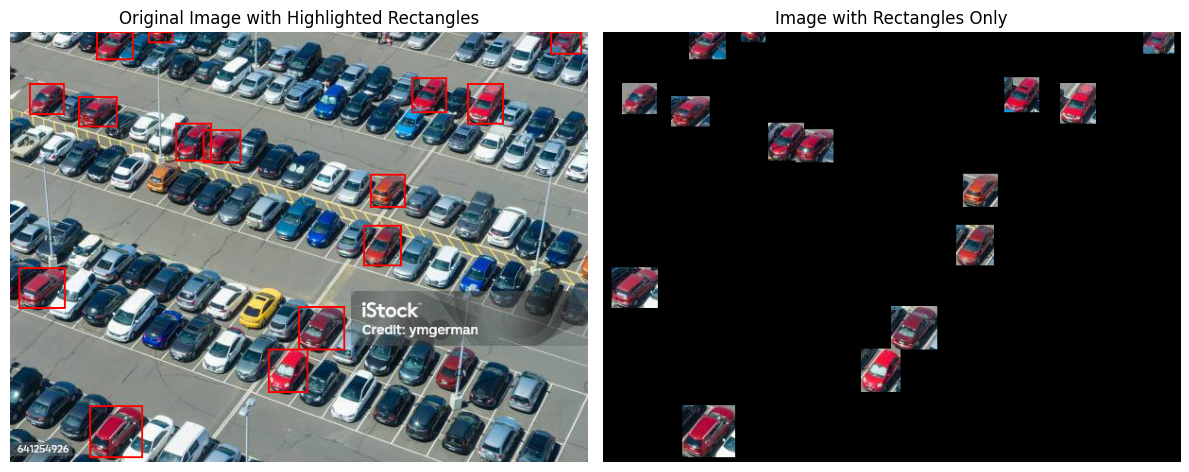

In [189]:
if len(filtered_data) == 0:
    print("No data found.")
else:
    original_image = Image.open("parking2.jpg")

    # Copia per disegnare i rettangoli sull'immagine originale
    highlighted_image = original_image.copy()
    draw = ImageDraw.Draw(highlighted_image)

    # Crea un'immagine nera per visualizzare solo i rettangoli
    rectangles_image = Image.new("RGB", original_image.size, (0, 0, 0))

    # Itera su ogni riga del dataset per ritagliare e disegnare i rettangoli
    for _, row in filtered_data.iterrows():
        # Estrai le coordinate come tuple esplicite
        rect_coords = [
            tuple(map(int, row["coord_1"])),
            tuple(map(int, row["coord_2"])),
            tuple(map(int, row["coord_3"])),
            tuple(map(int, row["coord_4"]))
        ]

        # Disegna il rettangolo sull'immagine originale
        draw.polygon(rect_coords, outline="red", width=2)

        # Ritaglia il rettangolo dall'immagine originale
        x1, y1 = rect_coords[0]
        x3, y3 = rect_coords[2]
        cropped_rectangle = original_image.crop((x1, y1, x3, y3))

        # Sovrapponi il rettangolo sull'immagine nera
        rectangles_image.paste(cropped_rectangle, (x1, y1))

    # Visualizza le immagini
    plt.figure(figsize=(12, 6))

    # Immagine originale con rettangoli evidenziati
    plt.subplot(1, 2, 1)
    plt.imshow(highlighted_image)
    plt.title("Original Image with Highlighted Rectangles")
    plt.axis("off")

    # Immagine composta solo dai rettangoli
    plt.subplot(1, 2, 2)
    plt.imshow(rectangles_image)
    plt.title("Image with Rectangles Only")
    plt.axis("off")

    plt.tight_layout()
    plt.show()